# 1 Load libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import itertools
import random # split datasets

# xgboost
import xgboost as xgb
from xgboost import XGBClassifier
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# lightgbm
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

#Random Forest
import sklearn.ensemble as ensemble
from sklearn.model_selection import GridSearchCV

# 2 Load datasets

In [3]:
train = pd.read_csv('data/train_after_missing_value_without_dropping_rows.csv')
test = pd.read_csv('data/test_after_missing_value_without_dropping_rows.csv')


In [4]:
train.fillna(999,inplace=True)
test.fillna(999,inplace=True)

In [5]:
print(train.shape)
print(test.shape)

(590540, 289)
(506691, 289)


For avoiding LightGBM error: 
`LightGBMError: Do not support special JSON characters in feature name.`, rename the features

In [5]:
import re
train = train.rename(columns = lambda x:re.sub(':', '', x))
test = test.rename(columns = lambda x:re.sub(':', '', x))

Train / Validation Split

In [6]:
y = pd.DataFrame(train['isFraud'])
X = train.drop(columns=['isFraud'])
X_test = test.drop(columns=['isFraud'])

In [7]:
index_array = np.arange(len(X))
val_index = index_array[random.sample(range(0,X.shape[0]), X.shape[0]//5)]
train_index = np.delete(index_array[:X.shape[0]], val_index, axis=0)
len(train_index), len(val_index)

(472432, 118108)

In [8]:
X_train, X_val = X.iloc[train_index], X.iloc[val_index]
y_train, y_val = y.iloc[train_index], y.iloc[val_index]

# 3 Modeling
## 3.1 XGboost
### 3.1.1 Training

In [14]:
%%time

prediction_test_fold = []

param = {'booster' : 'gbtree',
         'max_depth' : 8, #14
         'nthread' : -1,
         'num_class' : 1,
         'objective' : 'binary:logistic',
         'silent' : 1,
         'eval_metric' : 'auc',
         'eta' : 0.01,
         'tree_method' : 'gpu_hist',
         'min_child_weight' : 0,
         'colsample_bytree' : 0.8,
         'colsample_bylevel' : 0.8,
         'seed' : 2019}



    
print("Train Shape :", X_train.shape,
      "Validation Shape :", X_val.shape,
      "Test Shape :", X_test.shape)
    
dtrn = xgb.DMatrix(X_train, label=y_train, feature_names = X.columns)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = X.columns)
dtst = xgb.DMatrix(X_test, feature_names = X.columns)
    
xgb1 = xgb.train(param, dtrn, num_boost_round=10000, evals = [(dtrn, 'train'), (dval, 'eval')],
                 early_stopping_rounds = 200, verbose_eval=200)
                 
prediction_XGB = xgb1.predict(dtst) # prediction of test
#prediction_test_fold.append(prediction_XGB)

prediction_val_XGB = xgb1.predict(xgb.DMatrix(X_val, feature_names = X.columns)) # prediction of validation

Train Shape : (472432, 288) Validation Shape : (118108, 288) Test Shape : (506691, 288)
[02:19:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.84034	eval-auc:0.83141
[200]	train-auc:0.89172	eval-auc:0.87901
[400]	train-auc:0.92222	eval-auc:0.90440
[600]	train-auc:0.94494	eval-auc:0.92281
[800]	train-auc:0.95476	eval-auc:0.93219
[1000]	train-auc:0.95957	eval-auc:0.93665
[1200]	train-auc:0.96342	eval-auc:0.94013
[1400]	train-auc:0.96654	eval-auc:0.94285
[1600]	train-auc:0.96903	eval-auc:0.94504
[1800]	train-auc:0.97167	eval-auc:0.94715
[2000]	train-auc:0.97378	eval-auc:0.94902
[2200]	train-auc:0.97566	eval-auc:0.95065
[2400]	train-auc:0.97745	eval-auc:0.95220
[2600]	train-auc:0.97908	eval-auc:0.95334
[2800]	train-auc:0.98055	eval-auc:0.95453
[3000]	train-auc:0.98206	eval-auc:0.95574
[3200]	train-auc:0.98342	eval-auc:0.95687
[3400]	tr

### 3.1.2 Confusion matrix

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
metrics.accuracy_score(y_val, prediction_val_XGB.round())*100

98.61144037660446

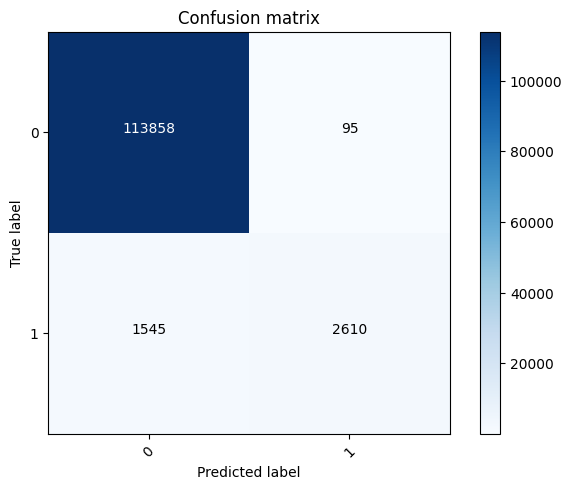

In [17]:
confusion_mtx = confusion_matrix(y_val, prediction_val_XGB.round()) 
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

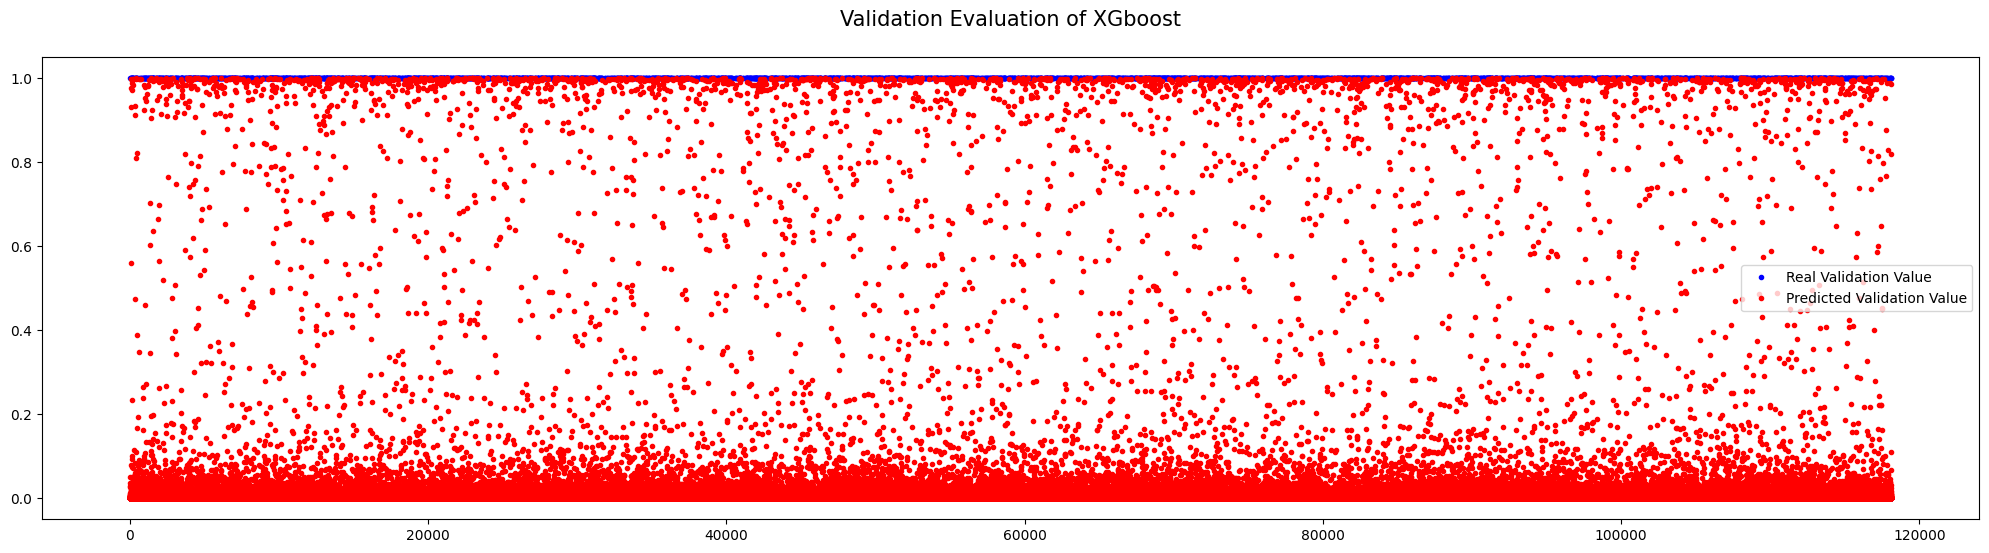

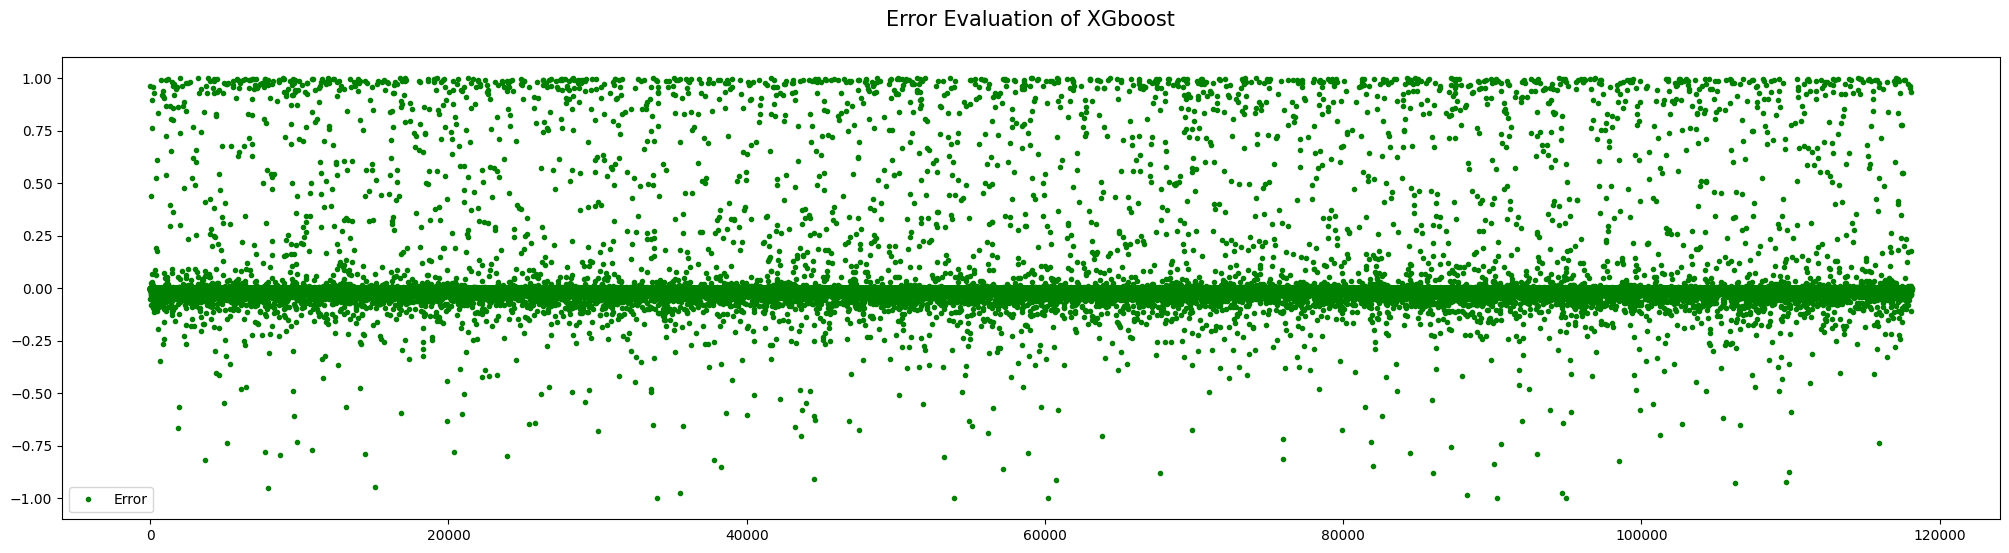

In [18]:
plt.figure(figsize = (25,6))
plt.title('Validation Evaluation of XGboost', y = 1.05, size = 15)
plt.plot(y_val.reset_index()['isFraud'], '.', label = 'Real Validation Value', color = 'blue')
plt.plot(prediction_val_XGB, '.', label = 'Predicted Validation Value', color = 'red')
plt.legend()
plt.show()

plt.figure(figsize = (25,6))    
plt.title('Error Evaluation of XGboost', y = 1.05, size = 15)
plt.plot(y_val.reset_index()['isFraud'] - prediction_val_XGB, '.', label = 'Error', color = 'green')
plt.legend()
plt.show()

## 3.2 LightGBM
### 3.2.1 Training

In [19]:
%%time

params = {'num_leaves': 500,
          'min_child_weight': 0.03,
          'feature_fraction': 0.35,
          'bagging_fraction': 0.35,
          'min_data_in_leaf': 100,
          'objective': 'binary',
          'max_depth': 14,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 10,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.2,
          'reg_lambda': 0.6,
          'random_state': 50,
          'device': 'gpu',
          'gpu_platform_id': 0,
          'gpu_device_id': 0
         }


dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=100, early_stopping_rounds=200)
    

prediction_LGB = model.predict(X_test)
prediction_val_LGB = model.predict(X_val)

d:\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
d:\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.937965	valid_1's auc: 0.913866
[200]	training's auc: 0.955158	valid_1's auc: 0.927673
[300]	training's auc: 0.968284	valid_1's auc: 0.937973
[400]	training's auc: 0.976763	valid_1's auc: 0.945355
[500]	training's auc: 0.982069	valid_1's auc: 0.951003
[600]	training's auc: 0.985509	valid_1's auc: 0.954902
[700]	training's auc: 0.988089	valid_1's auc: 0.957698
[800]	training's auc: 0.989651	valid_1's auc: 0.959539
[900]	training's auc: 0.990999	valid_1's auc: 0.961048
[1000]	training's auc: 0.992033	valid_1's auc: 0.962311
[1100]	training's auc: 0.992655	valid_1's auc: 0.963211
[1200]	training's auc: 0.993364	valid_1's auc: 0.964041
[1300]	training's auc: 0.993917	valid_1's auc: 0.964807
[1400]	training's auc: 0.994451	valid_1's auc: 0.965491
[1500]	training's auc: 0.994891	valid_1's auc: 0.966026
[1600]	training's auc: 0.995326	valid_1's auc: 0.966584
[1700]	training's auc: 0.995795	valid_1's auc: 0.96

### 3.2.2 Confusion matrix

In [18]:
metrics.accuracy_score(y_val, prediction_val_LGB.round())*100

NameError: name 'prediction_val_LGB' is not defined

In [19]:
confusion_mtx = confusion_matrix(y_val, prediction_val_LGB.round()) 
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

NameError: name 'prediction_val_LGB' is not defined

NameError: name 'prediction_val_LGB' is not defined

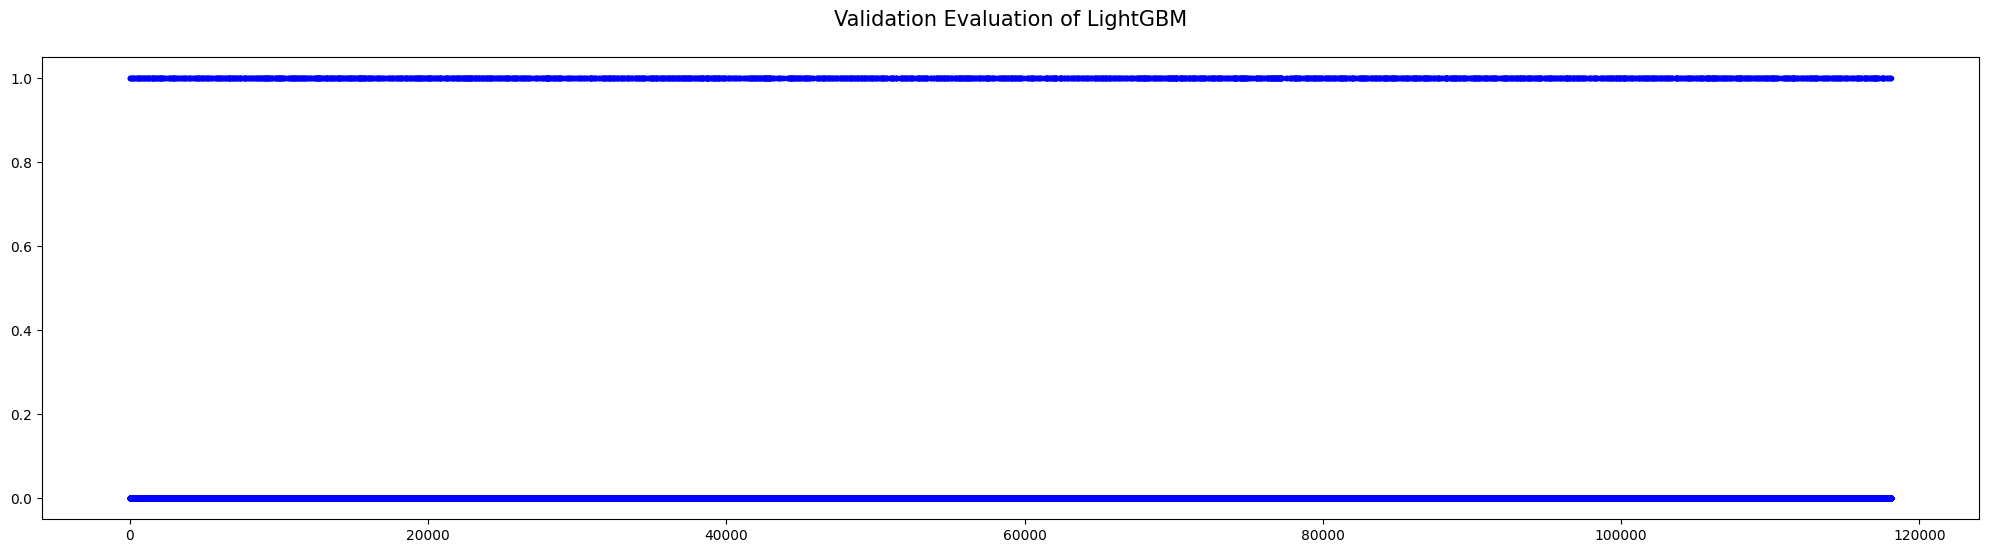

In [20]:
plt.figure(figsize = (25,6))
plt.title('Validation Evaluation of LightGBM', y = 1.05, size = 15)
plt.plot(y_val.reset_index()['isFraud'], '.', label = 'Real Validation Value', color = 'blue')
plt.plot(prediction_val_LGB, '.', label = 'Predicted Validation Value', color = 'red')
plt.legend()
plt.show()

plt.figure(figsize = (25,6))    
plt.title('Error Evaluation of LightGBM', y = 1.05, size = 15)
plt.plot(y_val.reset_index()['isFraud'] - prediction_val_LGB, '.', label = 'Error', color = 'green')
plt.legend()
plt.show()

# 4 Submission

In [23]:
sample_submission = pd.read_csv('input/sample_submission.csv', index_col='TransactionID')

In [24]:
sample_submission.shape

(506691, 1)

In [25]:
sample_submission['isFraud'] = np.nan
sample_submission.head()

,isFraud
TransactionID,
3663549,NaN
3663550,NaN
3663551,NaN
3663552,NaN
3663553,NaN


In [26]:
xgb_sub, lgb_sub = sample_submission, sample_submission

## 4.1 XGboost

In [27]:
xgb_sub['isFraud'] = (0.5 * prediction_XGB) + (0.5 * prediction_XGB)
xgb_sub.head()

,isFraud
TransactionID,
3663549,0.000401
3663550,0.000100
3663551,0.000119
3663552,0.000044
3663553,0.000300


In [28]:
xgb_sub[xgb_sub['isFraud'] > 0.1]

,isFraud
TransactionID,
3663769,0.633984
3663778,0.136651
3663811,0.123253
3663827,0.268099
3663828,0.133469
...,...
4170021,0.999363
4170032,0.560307
4170059,0.629494


In [29]:
xgb_sub.to_csv('submission/sample_xgboost.csv')

## 4.2 LightGBM

In [30]:
lgb_sub['isFraud'] = (0.5 * prediction_LGB) + (0.5 * prediction_LGB)
lgb_sub.head()

,isFraud
TransactionID,
3663549,0.000206
3663550,0.000077
3663551,0.000051
3663552,0.000060
3663553,0.000024


In [31]:
lgb_sub[xgb_sub['isFraud'] > 0.1]

,isFraud
TransactionID,
3663769,0.811388
3663773,0.115996
3663778,0.383421
3663780,0.259363
3663793,0.171963
...,...
4170032,0.237737
4170059,0.691866
4170069,0.101743


In [32]:
lgb_sub.to_csv('submission/sample_lightgbm.csv')

## 3.3 Random Forest
### 3.3.1 Training

In [10]:
train.fillna(999,inplace=True)
train.isnull().sum().sum()

0

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

param_grid = {
    'criterion':['entropy'],
    'max_depth':[10], # >   
    'n_estimators':[14],  # >  
    'max_features':[0.4], # >  
    'min_samples_split':[6]  
}

rfc = ensemble.RandomForestClassifier()
rfc_cv = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='roc_auc', cv=4)
rfc_cv.fit(X_train, y_train)

test_est = rfc_cv.predict(X_test)
print('RandomForest...')
print(metrics.classification_report(y_test, test_est))
print('RandomForest AUC...')
fpr_test, tpr_test, th_test = metrics.roc_curve(y_test, test_est) # 构造 roc 曲线
print('AUC = %.4f' %metrics.auc(fpr_test, tpr_test))

rfc_cv.best_params_

d:\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d a

RandomForest...
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    170910
         1.0       0.90      0.33      0.49      6252

    accuracy                           0.98    177162
   macro avg       0.94      0.67      0.74    177162
weighted avg       0.97      0.98      0.97    177162

RandomForest AUC...
AUC = 0.6660


{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 0.4,
 'min_samples_split': 6,
 'n_estimators': 14}

### 3.3.2 Confusion matrix

In [16]:
metrics.accuracy_score(y_test, test_est.round())*100

97.14950158611893

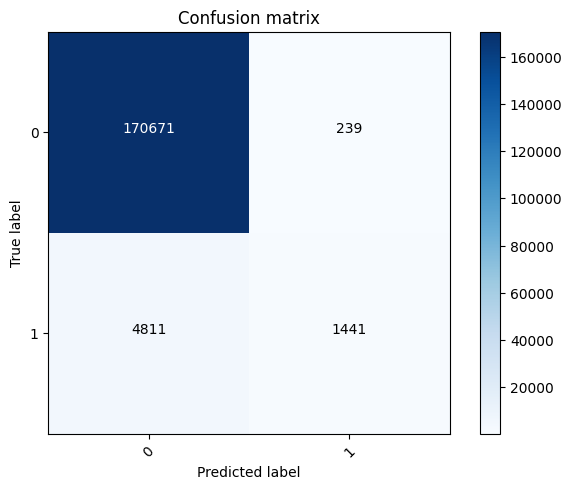

In [23]:
confusion_mtx = confusion_matrix(y_test, test_est.round()) 
plot_confusion_matrix(confusion_mtx, classes = range(2)) 